# Bilateral Bargaining: Evaluation of the Experiments

In [1]:
import os
import sys
import json
import numpy as np
import torch
import matplotlib.pyplot as plt

# pylint: disable=wrong-import-position
sys.path.append(os.path.realpath('.'))
sys.path.append(os.path.join(os.path.expanduser('~'), 'bnelearn'))

from bnelearn.util.metrics import ALIASES_LATEX
from scripts.utils import *

In [8]:
### EXP-1 BB 1/2-DA & VCG -----------------------------------------------------
path = '/home/kohring/bnelearn/experiments/debug/exp-1_experiment-v2'

path_kDA = path + '/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
path_kDA += os.listdir(path_kDA)[0]
path_VCG = path + '/double_auction/single_item/vcg/uniform/symmetric/risk_1.0/1b1s/'
path_VCG += os.listdir(path_VCG)[0] 

exps = dict()
exps['$0.5$-DA'] = path_kDA + '/aggregate_log.csv'
exps['VCG'] = path_VCG + '/aggregate_log.csv'

with open(path_kDA + '/experiment_configurations.json') as json_file:
    running = json.load(json_file)['running']
    n_runs, n_epochs = running['n_runs'], running['n_epochs']

csv_to_tex(
    experiments = exps,
    name = os.curdir + '/exp-1_table.tex',
    metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss'],
    caption = f"Mean and standard deviation over {'ten' if n_runs==10 else n_runs} runs of {int(n_epochs/1000)},000 iterations of the learning metrics for the two most common mechanisms in the bilateral bargaining setup. For the average double auction, we only compare the learned strategies to the payoff dominant equilibrium strategies.",
    symmetric = False,
    label = 'tab:exp-1_table'
)

In [ ]:
### EXP-2 risk experiments ----------------------------------------------------
path = '/home/kohring/bnelearn/experiments/debug/exp-2_experiment-v2'
path += '/double_auction/single_item/k_price/0.5/uniform/symmetric'
exps = dict()
for risk_str in sorted(next(os.walk(path))[1]):
    exps[float(risk_str[5:])] = get_sub_path(path + '/' + risk_str, 2) + '/aggregate_log.csv'

csv_to_tex(
    experiments = exps,
    name = os.curdir + '/exp-2_table.tex',
    metrics = ['eval_vs_bne/L_2', 'eval_vs_bne/epsilon_relative', 'eval/estimated_relative_ex_ante_util_loss'],
    symmetric = False,
    caption = 'Mean and standard deviation of experiments over ten runs' \
        + ' each for differnt risk attitutes of the buyer and seller.',
    label = 'tab:exp-2_table'
)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


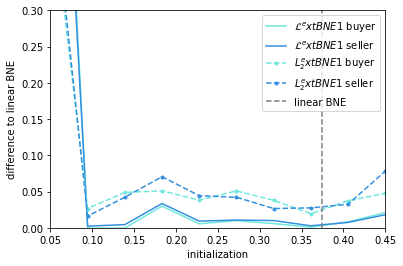

In [10]:
### EXP-3 custom pretraining experiments --------------------------------------
path = '/home/kohring/bnelearn/experiments/debug/exp-3_experiment-v2/double_auction/single_item/k_price/0.5/uniform/symmetric/risk_1.0/1b1s/'
metrics_names = ["eval_vs_bne/epsilon_relative", "eval_vs_bne/L_2"]
metrics_names_latex = ["$\mathcal{L}^\text{BNE{1}}$", "$L_2^\text{BNE{1}}$"]
exp_names = sorted(os.listdir(path))
metrics = np.zeros((2, len(metrics_names), len(exp_names)))

g_05s = np.zeros(len(exp_names))
for i, exp_name in enumerate(exp_names):
    with open(path + exp_name + '/experiment_configurations.json') as json_file:
        g_05s[i] = float(json.load(json_file)['setting']['pretrain_transform'])
    df = single_exp_logs_to_df(path=path + exp_name + '/aggregate_log.csv',
                               with_stddev=False, metrics=metrics_names)
    # print(df.columns)
    # buyer
    metrics[0, 0, i] = float(df[metrics_names_latex[0]][0])
    metrics[0, 1, i] = float(df[metrics_names_latex[1]][0])
    # seller
    metrics[1, 0, i] = float(df[metrics_names_latex[0]][1])
    metrics[1, 1, i] = float(df[metrics_names_latex[1]][1])

metrics[metrics != metrics] = np.inf

colors = ['#6FE7DD', '#3490DE', '#6639A6', '#521262']

plt.figure()
plt.plot(g_05s, metrics[0, 0], label=metrics_names_latex[0] + ' buyer', color=colors[0])
plt.plot(g_05s, metrics[1, 0], label=metrics_names_latex[0] + ' seller', color=colors[1])
plt.plot(g_05s, metrics[0, 1], '--.', label=metrics_names_latex[1] + ' buyer', color=colors[0])
plt.plot(g_05s, metrics[1, 1], '--.', label=metrics_names_latex[1] + ' seller', color=colors[1])
plt.plot([3./8., 3./8.], [0, 1], '--', color='grey', label=r'linear BNE')
plt.xlabel('initialization'); plt.ylabel('difference to linear BNE')
plt.xlim([g_05s[0], g_05s[-1]]); plt.ylim([0, .3])
plt.legend(loc='upper right')
plt.savefig(os.curdir + '/exp-3_figure.eps')
plt.show()